In [1]:
print("Plant diseases AI project")

Plant diseases AI project


### Importing all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as pr
import matplotlib.pyplot as plt

### Setting all the Constants

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 15

### Importing data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset

In [21]:
data_path = r"C:\Users\Administrator\Desktop\TIE 5.1\AI project\maize_data"
dataset = pr.image_dataset_from_directory(data_path, shuffle= False,
    image_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 4188 files belonging to 4 classes.


### Verifying the class names in the dataset imported

In [22]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [23]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Visualizing some sample images from the dataset

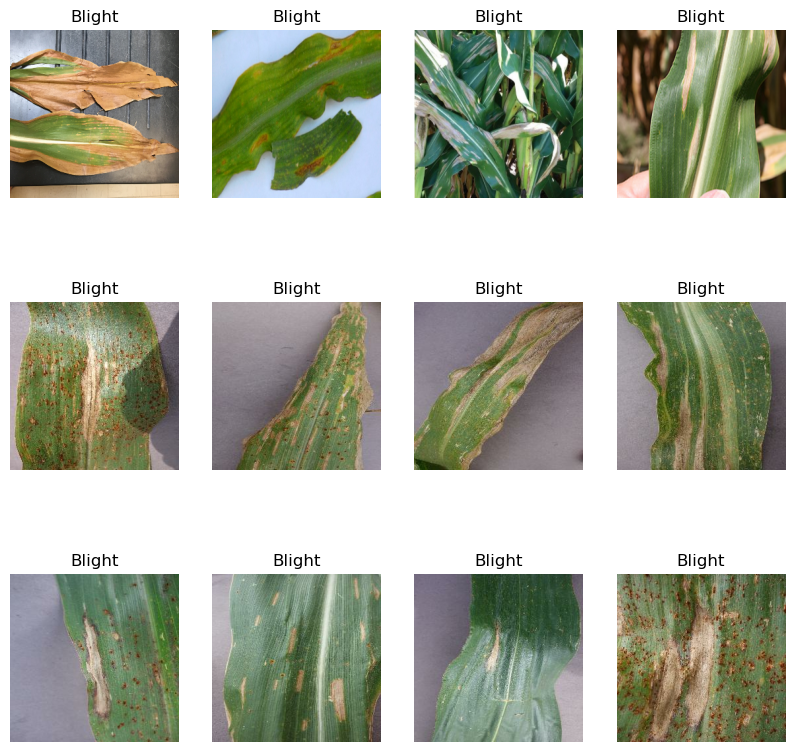

In [24]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Verifying the total length of our dataset

In [25]:
print(f"Dataset length is: {len(dataset)}")

Dataset length is: 131


### Function to divide the dataset into trainig, testing and validatio

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

### Verifying the lengths of the trainig, testing and validation datases

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Training dataset length: {len(train_ds)}")
print(f"Testing dataset length: {len(test_ds)}")
print(f"Validation dataset length: {len(val_ds)}")

Training dataset length: 104
Testing dataset length: 14
Validation dataset length: 13


### Cache, Shuffle, and Prefetch the Dataset

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

Creating a Layer for Resizing and Normalization

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

We used convolutional neural network (CNN) here.

In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### Getting our model summary

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Model Training

In [44]:
history = model.fit(
    train_ds,
    batch_size= BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCH,
)

Epoch 1/15
104/104 [==============================] - 395s 4s/step - loss: 1.3142 - accuracy: 0.2945 - val_loss: 1.1892 - val_accuracy: 0.3053
Epoch 2/15
104/104 [==============================] - 329s 3s/step - loss: 1.0131 - accuracy: 0.5262 - val_loss: 1.1478 - val_accuracy: 0.6130
Epoch 3/15
104/104 [==============================] - 339s 3s/step - loss: 0.9513 - accuracy: 0.5484 - val_loss: 1.1168 - val_accuracy: 0.3029
Epoch 4/15
104/104 [==============================] - 358s 3s/step - loss: 0.9013 - accuracy: 0.5391 - val_loss: 1.0915 - val_accuracy: 0.2957
Epoch 5/15
104/104 [==============================] - 431s 4s/step - loss: 0.8801 - accuracy: 0.5659 - val_loss: 1.0049 - val_accuracy: 0.3077
Epoch 6/15
104/104 [==============================] - 440s 4s/step - loss: 0.8617 - accuracy: 0.4862 - val_loss: 0.9986 - val_accuracy: 0.3101
Epoch 7/15
104/104 [==============================] - 420s 4s/step - loss: 1.0021 - accuracy: 0.5054 - val_loss: 1.0477 - val_accuracy: 0.3053

### Evaluating our model accuracy

In [50]:
scores = model.evaluate(test_ds)
print("Finish")

14/14 [==============================] - 11s 673ms/step - loss: 0.8057 - accuracy: 0.6763
Finish


You can see above that we get 67.63% accuracy for our test dataset.

### Plotting the Accuracy and Loss Curves

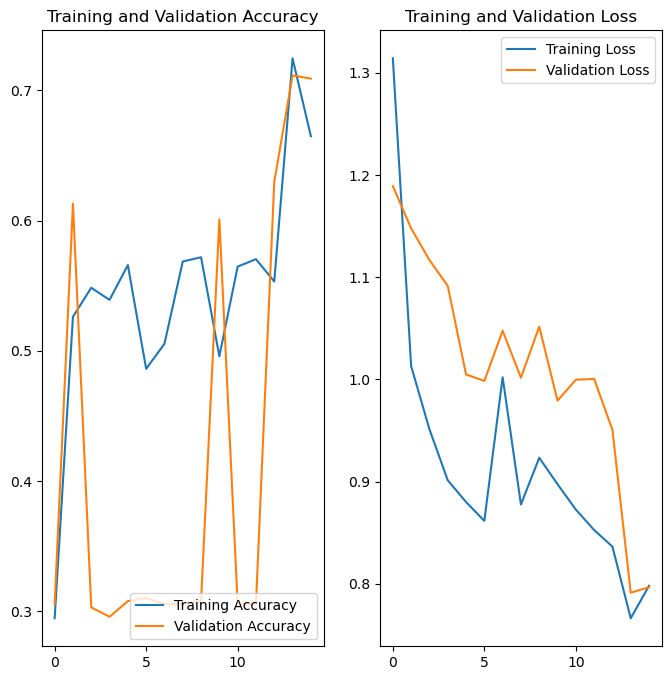

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Running prediction on a sample image

first image to predict
actual label: Blight
1/1 [==============================] - 5s 5s/step
predicted label: Blight


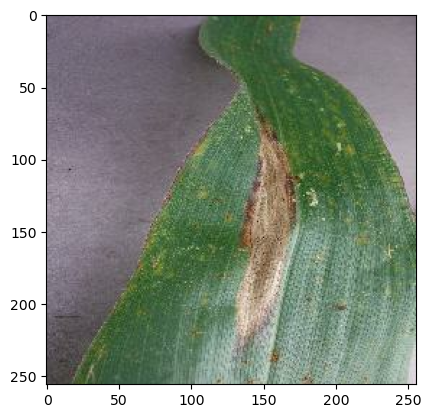

In [54]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Writing a function for inference

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Running the inference on few sample images for prediction and confidence rate

1/1 [==============================] - 1s 1s/step


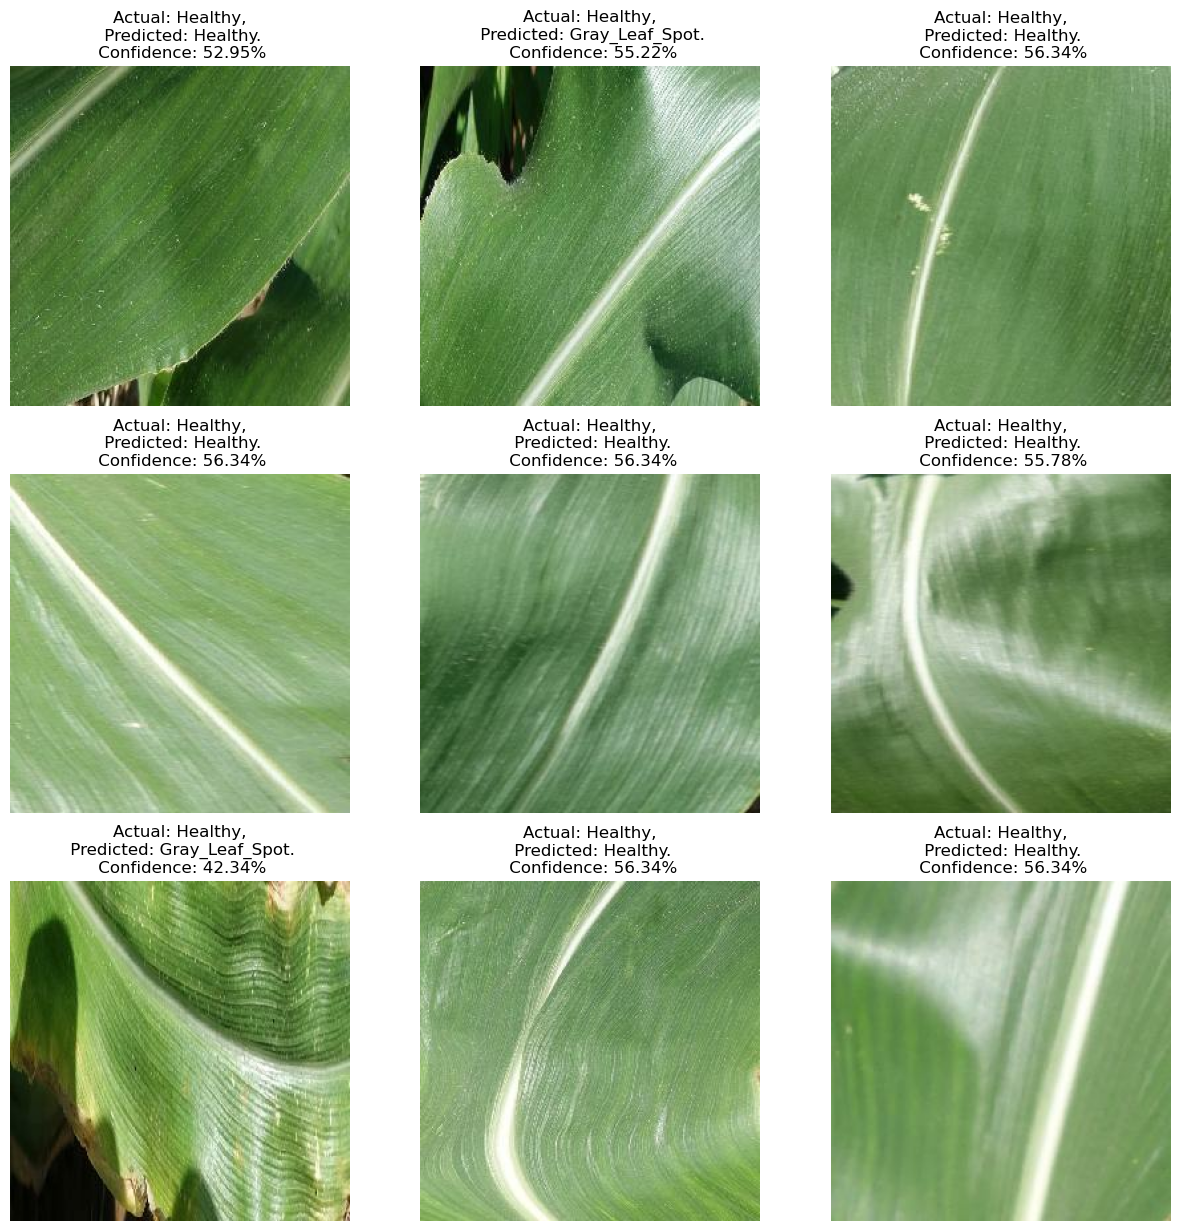

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model to our maize_model folder on google drive

We append the model to the list of models as a new version

In [61]:
import os
model_version=max([int(i) for i in os.listdir("./maize_models") + [0]])+1
model.save(f"./maize_models/{model_version}")

INFO:tensorflow:Assets written to: ./maize_models/1\assets


INFO:tensorflow:Assets written to: ./maize_models/1\assets
